<a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>

# Workshop Assessment 

Welcome to the assessment section of this course. In the previous labs you successfully applied machine learning and deep learning techniques for the task of anomaly detection on network packet data. Equipped with this background, you can apply these techniques to any type of data (images or audio) across different use cases. In this assessment, you will apply supervised and unsupervised techniques for intrusion detection on the NSL KDD dataset.

If you are successfully able to complete this assessment, you will be able to generate a certificate of competency for the course. Good luck!

## Objectives

This assessment seeks to test the following concepts:

1.   Building and training an Xgboost model.
2.   Building and training an autoencoder neural network.
3.   Detecting anomalies using different thresholding methods.

The total duration of the assessment is 2 hrs, however, if you are unable to complete the assessment today, you are more than welcome to return to it at a later time to try and complete it then.

## Section 1: Preparation - Done for You

### The Dataset

We will be using the NSL-KDD dataset published by the University of New Brunswick in this assessment. While the dataset is similar to the KDD dataset used throughout the workshop in terms of the features used, it varies in the following respects:

1.   Removal of redundant and duplicate records in the dataset to prevent classifiers from overfitting a particular class.
2.   The number of selected records from each difficulty level group is inversely proportional to the percentage of records in the original KDD data set making the task of unsupervised classification slightly more challenging.

### Imports

In [1]:
import numpy as np
import pandas as pd
import os
import random as python_random

import xgboost as xgb
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model

from collections import OrderedDict
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import roc_auc_score,confusion_matrix,classification_report,roc_curve

# We will use our own accuracy score functions for the sake of grading this assessment
from assessment import xgb_accuracy_score, autoencoder_accuracy_score

from tensorflow.keras.models import load_model, model_from_json

np.random.seed(42)
python_random.seed(42)
tf.random.set_seed(42)
os.environ['PYTHONHASHSEED']=str(42)

### Load the Data

In [2]:
col_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins","logged_in",
             "num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds",
             "is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
             "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
             "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
             "dst_host_srv_rerror_rate","label"]

df = pd.read_csv("data/KDDTrain+_20Percent.txt", header=None, names=col_names, index_col=False)

text_l = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login']

df.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [3]:
# Describe the different classes of Labels

pd.DataFrame(df['label'].value_counts())

,label
normal,13449
neptune,8282
ipsweep,710
satan,691
portsweep,587
smurf,529
nmap,301
back,196
teardrop,188
warezclient,181


### Data Preprocessing

In [4]:
# Create one-hot encoded categorical columns in the dataset

cat_vars = ['protocol_type', 'service', 'flag', 'land', 'logged_in','is_host_login', 'is_guest_login']

# Find unique labels for each category
cat_data = pd.get_dummies(df[cat_vars])

# Check that the categorical variables were created correctly
cat_data.head()

,land,logged_in,is_host_login,is_guest_login,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [5]:
# Separate the numerical columns

numeric_vars = list(set(df.columns.values.tolist()) - set(cat_vars))
numeric_vars.remove('label')
numeric_data = df[numeric_vars].copy()

# Check that the numeric data has been captured accurately

numeric_data.head()

,diff_srv_rate,dst_host_rerror_rate,wrong_fragment,dst_bytes,urgent,num_root,num_file_creations,srv_rerror_rate,num_shells,srv_diff_host_rate,...,num_access_files,srv_serror_rate,dst_host_srv_serror_rate,dst_host_srv_rerror_rate,hot,same_srv_rate,dst_host_srv_count,serror_rate,num_failed_logins,dst_host_same_srv_rate
0,0.00,0.05,0,0,0,0,0,0.0,0,0.00,...,0,0.0,0.00,0.00,0,1.00,25,0.0,0,0.17
1,0.15,0.00,0,0,0,0,0,0.0,0,0.00,...,0,0.0,0.00,0.00,0,0.08,1,0.0,0,0.00
2,0.07,0.00,0,0,0,0,0,0.0,0,0.00,...,0,1.0,1.00,0.00,0,0.05,26,1.0,0,0.10
3,0.00,0.00,0,8153,0,0,0,0.0,0,0.00,...,0,0.2,0.01,0.01,0,1.00,255,0.2,0,1.00
4,0.00,0.00,0,420,0,0,0,0.0,0,0.09,...,0,0.0,0.00,0.00,0,1.00,255,0.0,0,1.00


In [6]:
numeric_cat_data = pd.concat([numeric_data, cat_data], axis=1)

## Assessment Task 1: Data Selection

The first part of this assessment checks whether you understand the data you are working with. If successful, you should be able to load and split the data in order to begin learning from it.

In the code block below, replace each #### FIX ME #### with solutions which:
1.   Determine the number of classes in the dataset.
2.   Set the variable test_size to the fraction of the dataset you would like to use for testing.

In [8]:
# Capture the labels
labels = df['label'].copy()

# Convert labels to integers
le = LabelEncoder()
integer_labels = le.fit_transform(labels)
num_labels = len(np.unique(labels)) ## FIXED ##

# Split data into test and train
x_train, x_test, y_train, y_test = train_test_split(numeric_cat_data,
                                                    integer_labels,
                                                    test_size= 0.25, #### FIXED #### 
                                                    random_state= 42)

In [9]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(18894, 118)
(18894,)
(6298, 118)
(6298,)


In [10]:
# Make sure to only fit the the scaler on the training data
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Convert the data to FP32
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

## Assessment Task 2 : XGBoost - Set the XGBoost Parameters

Treat the question as a **multi-class** supervised learning problem and train a **GPU-accelerated XGBoost model** on the given dataset. Refer to the [documentation](https://xgboost.readthedocs.io/en/latest/parameter.html) or your previous tasks to fix the parameter list. You may reference the notebooks from previous sections by opening the file explorer on the left-hand side of the JupyterLab screen.

This task checks that you know how these parameters impact training.

In [11]:
params = {
    'num_rounds':        10, ### FIXED ###
    'max_depth':         8, ### FIXED ###
    'max_leaves':        2**8,
    'alpha':             0.9,
    'eta':               0.1,
    'gamma':             0.1,
    'learning_rate':     0.1, ### FIXED ###
    'subsample':         1,
    'reg_lambda':        1,
    'scale_pos_weight':  2,
    'tree_method':       "gpu_hist", ### FIXED ###
    'n_gpus':            1,
    'objective':         "multi:softprob", ### FIXED ###
    'num_class':         22, ### FIXED ###
    'verbose':           True
}

## Assessment Task 3: Model Training

In this next task, you will prove that you can build and fit an accelerated XGBoost Model.
1.   Initiate training by referring to the [XGBoost API](https://xgboost.readthedocs.io/en/latest/python/python_api.html) documentation.
2.   Fit the model on test data to obtain the predictions.

In [12]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
evals = [(dtest, 'test',), (dtrain, 'train')]

num_rounds = params['num_rounds']

model = xgb.train(params,dtrain,num_rounds,evals=evals) #### FIXED ####

[21:46:31] WARNING: ../src/learner.cc:576: 
Parameters: { "n_gpus", "num_rounds", "scale_pos_weight", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:46:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	test-mlogloss:2.06686	train-mlogloss:2.06747
[1]	test-mlogloss:1.70072	train-mlogloss:1.70039
[2]	test-mlogloss:1.45067	train-mlogloss:1.44993
[3]	test-mlogloss:1.26049	train-mlogloss:1.25919
[4]	test-mlogloss:1.10776	train-mlogloss:1.10599
[5]	test-mlogloss:0.98102	train-mlogloss:0.97874
[6]	test-mlogloss:0.87372	train-mlogloss:0.87109
[7

In [13]:
preds = model.predict(dtest) #### FIXED ####
print(preds)

true_labels = y_test
true_labels

[[0.03265709 0.03271218 0.03266538 ... 0.03265695 0.0326893  0.03267832]
 [0.01884467 0.01887646 0.01884946 ... 0.01884459 0.01886326 0.01885693]
 [0.02149509 0.02153136 0.02150055 ... 0.021495   0.0215163  0.02150908]
 ...
 [0.0214987  0.02153497 0.02150416 ... 0.02149861 0.02151991 0.02151269]
 [0.0214987  0.02153497 0.02150416 ... 0.02149861 0.02151991 0.02151269]
 [0.0214987  0.02153497 0.02150416 ... 0.02149861 0.02151991 0.02151269]]


array([17, 11,  9, ...,  9,  9,  9])

In [14]:
# If predictions > 0.5, pred_labels = 1 else pred_labels = 0

pred_labels = np.argmax(preds, axis=1) #### FIXED ####
pred_labels

array([17, 11,  9, ...,  9,  9,  9])

Get the accuracy score for your model's predictions. In order to pass this part of the assessment, you need to attain an accuracy greater than 90%.

In [15]:
# NOTE: We are using our own accuracy score function in order to help grade the assessment,
# though it will behave here exactly like its scikit-learn couterpart `accuracy_score`.
xgb_acc = xgb_accuracy_score(true_labels, pred_labels)
print ('XGBoost Accuracy Score :', xgb_acc)

XGBoost Accuracy Score : 0.9947602413464592


## Assessment Task 4: Implement a Confusion Matrix

Show that you can determine the performance of your model by implementing a confusion matrix.

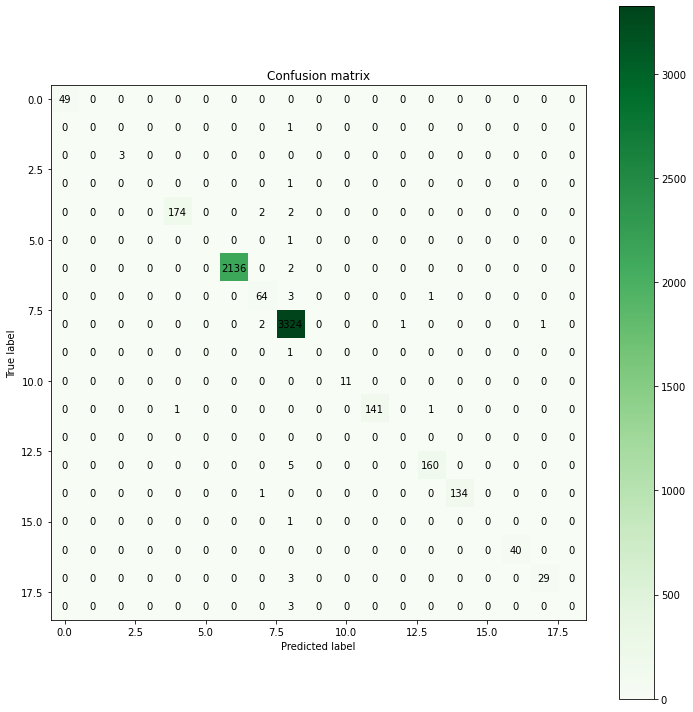

In [16]:
cm = confusion_matrix(true_labels, pred_labels)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greens):
    plt.figure(figsize=(10,10),)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)

# Autoencoder Model

As the second major part of this assessment, you get to train your own autoencoder neural network to understand inherant clusters in your data. Build an autoencoder treating this as a brinary classification problem. Feel free to open the file viewer on the left of the JupyterLab environment to view the notebooks from previous sections if you need a reference to guide your work.

![alt text](https://drive.google.com/uc?id=1gexBTwBnK_LtTmxrZp_opHD1xaAd2oum)

## Assessment Task 5: Set the Hyperparameters 

In [17]:
input_dim = x_train.shape[1]

# Model hyperparameters
batch_size = 512 #### FIXED ####

# Latent dimension: higher values add network capacity 
# while lower values increase efficiency of the encoding
latent_dim = 4 #### FIXED ####

# Number of epochs: should be high enough for the network to learn from the data, 
# but not so high as to overfit the training data or diverge
max_epochs = 20

learning_rate = 1e-5 #### FIXED ####

## Assessment Task 6: Build the Encoder Segment

1.   Fix the dimensions of the input (number of features in the dataset) in the input layer.
2.   Define the hidden layers of the encoder. We recommended using at least 3-4 layers.
3.   Consider adding dropout layers to the encoder to help avoid overfitting.
4.   Experiment with different activation functions (relu, tanh, sigmoid etc.).

Feel free to open the file viewer on the left of the JupyterLab environment to view the notebooks from previous sections if you need a reference to guide your work.

In [18]:
# The encoder will consist of a number of dense layers that decrease in size 
# as we taper down towards the bottleneck of the network: the latent space.

input_data = Input(shape=(input_dim,), name='encoder_input') #### FIXED ####

# Hidden layers
encoder = Dense(units= 96,activation='tanh', name='encoder_1')(input_data) #### FIXED ####
                
# Make your Encoder Deeper
encoder = Dropout(.1)(encoder)
encoder = Dense(units= 64,activation='tanh', name='encoder_2')(encoder)
encoder = Dropout(.1)(encoder)
encoder = Dense(units= 48,activation='tanh', name='encoder_3')(encoder)
encoder = Dropout(.1)(encoder)
encoder = Dense(units= 16,activation='tanh', name='encoder_4')(encoder)
encoder = Dropout(.1)(encoder)   

# Bottleneck layer
latent_encoding = Dense(latent_dim, activation='linear', name='latent_encoding')(encoder) #### FIXED ####

In [19]:
# We instantiate the encoder model, look at a summary of it's layers, and visualize it.

encoder_model = Model(input_data, latent_encoding)

encoder_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 118)]             0         
                                                                 
 encoder_1 (Dense)           (None, 96)                11424     
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 encoder_2 (Dense)           (None, 64)                6208      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 encoder_3 (Dense)           (None, 48)                3120      
                                                                 
 dropout_2 (Dropout)         (None, 48)                0     

## Assessment Task 7: Build Decoder Segment

1.    Fix the dimensions of the input to the decoder. 
2.    Grow the network from the latent layer to the output layer of size equal to the input layer.
3.    Experiment with different activation functions (tanh, relu, sigmoid etc.).

In [20]:
# The decoder network is a mirror image of the encoder network.
decoder = Dense(units=16, activation='tanh', name='decoder_1')(latent_encoding)
decoder = Dropout(.1)(decoder)
decoder = Dense(units=48, activation='tanh', name='decoder_2')(decoder)
decoder = Dropout(.1)(decoder)
decoder = Dense(units=64, activation='tanh', name='decoder_3')(decoder)
decoder = Dropout(.1)(decoder)
decoder = Dense(units=96, activation='tanh', name='decoder_4')(decoder)
decoder = Dropout(.1)(decoder)
# The output is the same dimension as the input data we are reconstructing.
reconstructed_data = Dense(units = input_dim, activation='linear', name='reconstructed_data')(decoder)

In [21]:
# We instantiate the encoder model, look at a summary of its layers, and visualize it.
autoencoder_model = Model(input_data, reconstructed_data)

autoencoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 118)]             0         
                                                                 
 encoder_1 (Dense)           (None, 96)                11424     
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 encoder_2 (Dense)           (None, 64)                6208      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 encoder_3 (Dense)           (None, 48)                3120      
                                                                 
 dropout_2 (Dropout)         (None, 48)                0   

## Assessment Task 8: Initiate Training of the Model

1.   Fix the learning rate *Hint: Think in the order of 10e-4*.
2.   Choose an appropriate error metric for the loss function (mse, rmse, mae etc.).
3.   Think about whether you want to shuffle your dataset during training.
4.   Initiate training of the autoencoder on the given dataset.

In [22]:
opt = optimizers.Adam(learning_rate=1e-5) #### FIXED ####

autoencoder_model.compile(optimizer=opt, loss="mse") #### FIXED ####

In [23]:
train_history = autoencoder_model.fit(x_train, x_train, #### FIXED ####
        shuffle= True, #### FIXED ####
        epochs=max_epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Epoch 1/20
37/37 [==============================] - 1s 5ms/step - loss: 0.0799 - val_loss: 0.0691
Epoch 2/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0763 - val_loss: 0.0664
Epoch 3/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0736 - val_loss: 0.0642
Epoch 4/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0713 - val_loss: 0.0623
Epoch 5/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0693 - val_loss: 0.0607
Epoch 6/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0676 - val_loss: 0.0592
Epoch 7/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0660 - val_loss: 0.0578
Epoch 8/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0646 - val_loss: 0.0565
Epoch 9/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0633 - val_loss: 0.0553
Epoch 10/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0620 - val_loss: 0.0540
Epoch 11/20
37/37 [

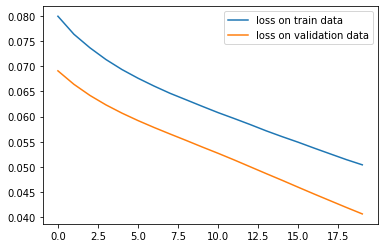

In [24]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.legend(['loss on train data', 'loss on validation data'])

## Assessment Task 9: Computing Reconstruction Errors

1.    Fit the trained model on the test dataset. 
2.    Compute the reconstruction scores using MSE as the error metric.

In [25]:
 # Reconstruct the data using our trained autoencoder model
x_test_recon = autoencoder_model.predict(x_test) #### FIXED ####

# The reconstruction score is the mean of the reconstruction errors (relatively high scores are anomalous)
reconstruction_scores = np.mean((x_test - x_test_recon)**2, axis=1)

197/197 [==============================] - 0s 753us/step


In [26]:
# Store the reconstruction data in a Pandas dataframe
anomaly_data = pd.DataFrame({'recon_score':reconstruction_scores})

def convert_label_to_binary(labels):
    my_labels = labels.copy()
    my_labels[my_labels != 11] = 1 
    my_labels[my_labels == 11] = 0
    return my_labels
  
# Convert our labels to binary
binary_labels = convert_label_to_binary(y_test)

# Add the binary labels to our anomaly dataframe
anomaly_data['binary_labels'] = binary_labels

# Let's check if the reconstruction statistics are different for labeled anomalies
anomaly_data.groupby(by='binary_labels').describe()

recon_score                                                    \
                    count      mean       std       min       25%       50%   
binary_labels                                                                 
0                  3328.0  0.029475  0.009423  0.019585  0.022682  0.025747   
1                  2970.0  0.053265  0.009368  0.020487  0.050276  0.053139   

                                   
                    75%       max  
binary_labels                      
0              0.033841  0.104219  
1              0.055698  0.088473

## Assessment Task 10: Anomaly Detection

1.   Plot the area under the curve
2.   Set the optimal threshold that separates normal packets from anomalous packets. 
3.   Threshold should be calculated as the difference between the true positive rate and false positive rate.

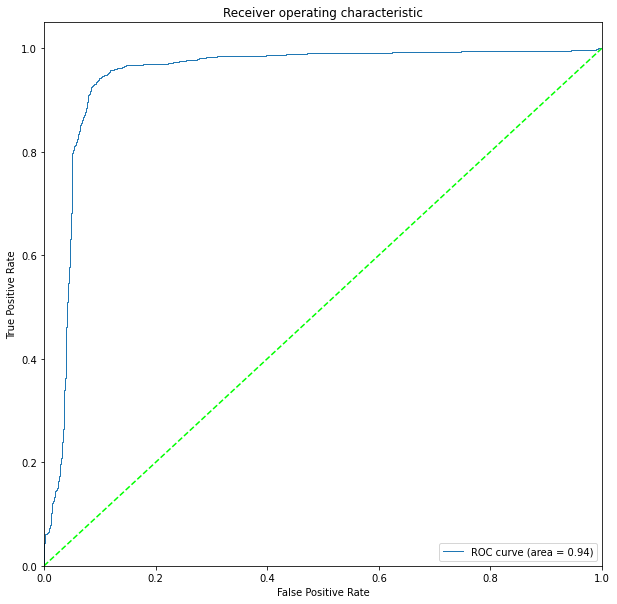

In [27]:
fpr, tpr, thresholds = roc_curve(binary_labels, reconstruction_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='lime', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [28]:
# We can pick the threshold based on the differeence between  the true positive rate (tpr) 
# and the false positive rate (fpr)
optimal_threshold_idx = np.argmax(tpr - fpr) #### FIXED ####
optimal_threshold = thresholds[optimal_threshold_idx]
print(optimal_threshold)

0.039802395


In [29]:
# Use the optimal threshold value you just printed in the previous cell.
thresh = optimal_threshold #### FIXED ####

print(thresh)

pred_labels = (reconstruction_scores > thresh).astype(int)

results = confusion_matrix(binary_labels, pred_labels)
# We are using our own accuracy score function in order to grade the assessment
ae_acc = autoencoder_accuracy_score(binary_labels, pred_labels)
print ('Autoencoder Accuracy Score :', autoencoder_accuracy_score(binary_labels, pred_labels))

0.039802395
Autoencoder Accuracy Score : 0.9199745951095586


In order to pass the assessment, you need to an accuracy of at least 90%.

### Confusion Matrix

This time, we'll create the confusion matrix for you.

Confusion Matrix: 


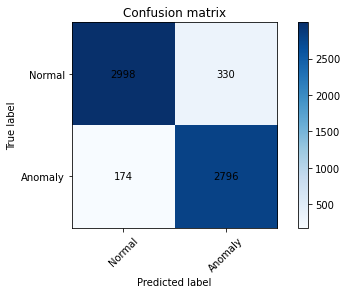

In [30]:
print ('Confusion Matrix: ')

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plot_confusion_matrix(results, ['Normal','Anomaly'])

## Assessment Task 11: Check Your Assessment Score

Before proceeding, confirm your XGBoost model accuracy is greater than 95% and that your autoencoder accuracy is greater than 90%. If it isn't please continue work on the notebook until you've met these benchmarks.

In [31]:
print ("Accuracy of the XGBoost Model: ", xgb_acc)
print ("Accuracy of the Autoencoder Model: ", ae_acc)

Accuracy of the XGBoost Model:  0.9947602413464592
Accuracy of the Autoencoder Model:  0.9199745951095586


Run the following cell to grade your assessment.

In [32]:
from assessment import run_assessment
run_assessment()

Testing your XGBoost solution
Required accuracy greater than 95%....
Your XGBoost model is accurate enough!

Testing your autoencoder solution
Required accuracy greater than 90%....
Your autoencoder model is accurate enough!

You passed the assessment. Congratulations!!!!!

See instructions below for how to get credit for your work.


If the cell above tells you that you passed the assessment, read below for instructions on how to get credit for your work.

### Get Credit for Your Work

To get credit for your assessment and generate a certificate of competency for the course, return to the browser tab where you opened this JupyterLab environment and click the "ASSESS TASK" button, as shown below:

![get_credit](images/get_credit.png)

<a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>